In [80]:
from torch import nn, optim
import numpy as np
import pickle as p
import torch
from tqdm.notebook import trange
from tqdm import tqdm
import matplotlib.pyplot as plt

from network import ConvNet
from resnet import ResNet
from sklearn.metrics import f1_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataset import CogDatasetTest
from meanAveragePrecision import computeMeanAveragePrecision
import helpers

In [81]:
# function for training and evaluation
def test(model, test_dataloader):
    accuracies = []
    f1s = []
    softmax_scores = []

    with torch.no_grad():

        model.eval()

        running_accuracy = 0.0
        conf_mat = torch.zeros(55,55)

        for input, target in test_dataloader:
            
            output = model(input)

            prediction = torch.argmax(output, dim=1).float() 
            softmax = torch.softmax(output, dim=1)

            for o, t in zip(prediction, target):
                if o == t:
                    running_accuracy+=1/(len(test_dataloader)*batch_size)
                
            #running_f1 += f1_score(target, prediction)
            conf_mat += helpers.confusion_mat(output, target)

            #running_f1 /= len(val_dataloader)

            accuracies.append(running_accuracy)
            #f1_val.append(running_f1)
            softmax_scores.append(softmax.tolist())

            # output
            if (len(accuracies) % 20 == 0 or len(accuracies) == len(test_dataloader)):
                tqdm.write('No. {} (test) -- acc: {:.4f}'.format(len(accuracies), running_accuracy))

        # mean average precision
        softmax_scores = np.asarray(softmax_scores).squeeze(1)
        mean_avg_precision, _ = computeMeanAveragePrecision(labels, softmax_scores)

        # f1 score
        f1 = helpers.f1_score(conf_mat)


        # print last value of metrics
        tqdm.write('Final accuracy: {:.4f}, mean avg precision {:.4f}, f1: {:.4f}'.format(running_accuracy, mean_avg_precision, f1))


    # make metrics callable outside this function
    test.accuracy = accuracies
    test.f1 = f1
    test.mean_avg_precision = mean_avg_precision

In [82]:
# load data and label files
# shape = [2284, 200, 3, 9] --> [datasets, time series, channels, devices]
data = p.load(open(r"data/test.pkl", "rb"))
labels = p.load(open(r"data/labels_test.pkl", "rb"))
print(data.shape)
print(labels.shape)

#reshape data into datasets x (channels x devices) x time series 
data = data.transpose((0,1,3,2))
data = data.reshape(data.shape[0], -1, data.shape[3])
print(data.shape)

batch_size = 1
# create datasets
test_dataset = CogDatasetTest(data, labels)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

(2288, 8, 200, 3)
(2288,)
(2288, 24, 200)


In [83]:
# load model for testing
net_num = 2
model = ResNet()
model.load_state_dict(torch.load("trained_models/net_" + str(net_num) + ".pt"))

<All keys matched successfully>

In [84]:
# test model
test(model.double(), test_dataloader)

No. 20 (test) -- acc: 0.0061
No. 40 (test) -- acc: 0.0118
No. 60 (test) -- acc: 0.0175
No. 80 (test) -- acc: 0.0236
No. 100 (test) -- acc: 0.0302
No. 120 (test) -- acc: 0.0354
No. 140 (test) -- acc: 0.0415
No. 160 (test) -- acc: 0.0463
No. 180 (test) -- acc: 0.0520
No. 200 (test) -- acc: 0.0581
No. 220 (test) -- acc: 0.0634
No. 240 (test) -- acc: 0.0704
No. 260 (test) -- acc: 0.0747
No. 280 (test) -- acc: 0.0787
No. 300 (test) -- acc: 0.0835
No. 320 (test) -- acc: 0.0887
No. 340 (test) -- acc: 0.0940
No. 360 (test) -- acc: 0.0997
No. 380 (test) -- acc: 0.1058
No. 400 (test) -- acc: 0.1123
No. 420 (test) -- acc: 0.1180
No. 440 (test) -- acc: 0.1250
No. 460 (test) -- acc: 0.1302
No. 480 (test) -- acc: 0.1359
No. 500 (test) -- acc: 0.1416
No. 520 (test) -- acc: 0.1464
No. 540 (test) -- acc: 0.1538
No. 560 (test) -- acc: 0.1595
No. 580 (test) -- acc: 0.1661
No. 600 (test) -- acc: 0.1700
No. 620 (test) -- acc: 0.1757
No. 640 (test) -- acc: 0.1814
No. 660 (test) -- acc: 0.1884
No. 680 (test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


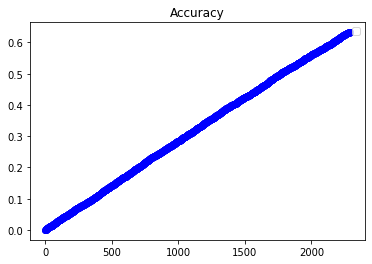

In [85]:
# plot metrics

# accuracy
plt.scatter(np.arange(len(test.accuracy)), test.accuracy, color="b")
plt.title("Accuracy")
plt.legend()
plt.show()